## Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 20-step windows for training. Every 20 steps is 1 trading month since the markets are only open Monday - Friday.

In [ ]:
# Read in data
spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6947


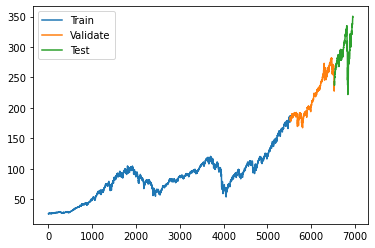

In [ ]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [ ]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

### Linear Model

In [ ]:
# Clears any background saved info useful in notebooks
keras.backend.clear_session()

# Make reproducible 
tf.random.set_seed(42)
np.random.seed(42)

# set window size 
window_size = 20

# define training data (20 day windows shifted by 1 every time)
train_set = window_dataset(normalized_x_train.flatten(), window_size)

# Build Linear Model of a single dense layer
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# Find optimal learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.Nadam(lr=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0479 - mae: 0.2662
Epoch 2/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0473 - mae: 0.2646
Epoch 3/100
172/172 [==============================] - 1s 5ms/step - loss: 0.0469 - mae: 0.2632
Epoch 4/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0464 - mae: 0.2617
Epoch 5/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0458 - mae: 0.2602
Epoch 6/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0453 - mae: 0.2585
Epoch 7/100
172/172 [==============================] - 1s 5ms/step - loss: 0.0447 - mae: 0.2567
Epoch 8/100
172/172 [==============================] - 1s 5ms/step - loss: 0.0440 - mae: 0.2548
Epoch 9/100
172/172 [==============================] - 1s 5ms/step - loss: 0.0433 - mae: 0.2528
Epoch 10/100
172/172 [==============================] - 1s 4ms/step - loss: 0.0426 - mae: 0.2506
Epoch 11/100
172/172 [=================

(1e-06, 1.0, 0.0, 0.01)

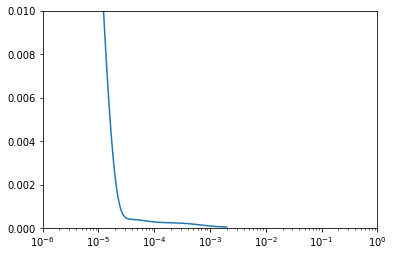

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 0, .01])

In [ ]:
# Useful to clear everything when rerunning cells
keras.backend.clear_session()

# Make this reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Create train and validate windows
window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# 1 layer producing linear output for 1 output from each window of 20 days
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# Huber works well with "mae"
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# fit model to data
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])



Epoch 1/500
    140/Unknown - 1s 5ms/step - loss: 0.0099 - mae: 0.0860INFO:tensorflow:Assets written to: my_checkpoint/assets
172/172 [==============================] - 1s 7ms/step - loss: 0.0081 - mae: 0.0742 - val_loss: 0.0018 - val_mae: 0.0511
Epoch 2/500
172/172 [==============================] - 1s 7ms/step - loss: 4.0522e-04 - mae: 0.0221 - val_loss: 0.0011 - val_mae: 0.0379
Epoch 3/500
172/172 [==============================] - 1s 7ms/step - loss: 2.1834e-04 - mae: 0.0166 - val_loss: 6.6286e-04 - val_mae: 0.0277
Epoch 4/500
172/172 [==============================] - 1s 7ms/step - loss: 1.3199e-04 - mae: 0.0128 - val_loss: 4.3824e-04 - val_mae: 0.0210
Epoch 5/500
172/172 [==============================] - 1s 7ms/step - loss: 1.0304e-04 - mae: 0.0108 - val_loss: 3.8833e-04 - val_mae: 0.0196
Epoch 6/500
172/172 [==============================] - 1s 5ms/step - loss: 9.5140e-05 - mae: 0.0099 - val_loss: 3.9236e-04 - val_mae: 0.0197
Epoch 7/500
172/172 [==============================]

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
lin_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

In [ ]:
# Undo the scaling
lin_forecast = x_train_scaler.inverse_transform(lin_forecast.reshape(-1,1)).flatten()
lin_forecast.shape

(420,)

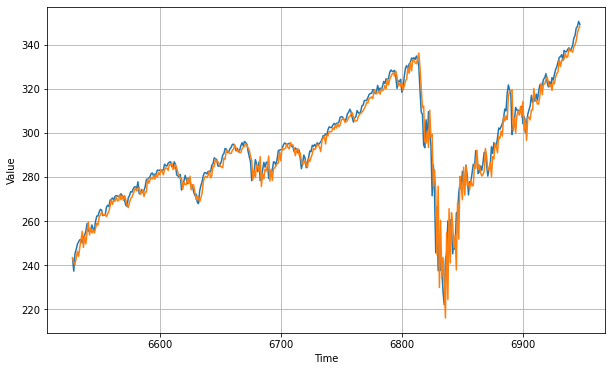

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test)
plot_series(x_test.index, lin_forecast)

#### Linear Model Result

In [ ]:
keras.metrics.mean_absolute_error(x_test, lin_forecast).numpy()

3.6513362

### Dense Model Forecasting

#### Find Learning Rate

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Nadam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 1s 5ms/step - loss: 127.5863 - mae: 128.0863
Epoch 2/100
172/172 [==============================] - 1s 5ms/step - loss: 127.4998 - mae: 127.9998
Epoch 3/100
172/172 [==============================] - 1s 4ms/step - loss: 127.4090 - mae: 127.9090
Epoch 4/100
172/172 [==============================] - 1s 6ms/step - loss: 127.3074 - mae: 127.8074
Epoch 5/100
172/172 [==============================] - 1s 4ms/step - loss: 127.1953 - mae: 127.6953
Epoch 6/100
172/172 [==============================] - 1s 6ms/step - loss: 127.0697 - mae: 127.5697
Epoch 7/100
172/172 [==============================] - 1s 5ms/step - loss: 126.9290 - mae: 127.4290
Epoch 8/100
172/172 [==============================] - 1s 5ms/step - loss: 126.7714 - mae: 127.2714
Epoch 9/100
172/172 [==============================] - 1s 4ms/step - loss: 126.5948 - mae: 127.0948
Epoch 10/100
172/172 [==============================] - 1s 5ms/step - loss: 126.3966 - mae: 126.8966

(1e-07, 0.005, 0.0, 30.0)

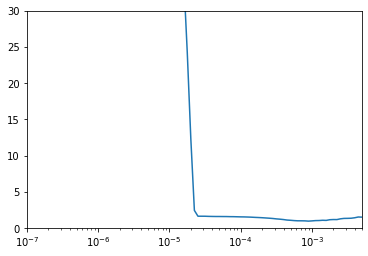

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

#### Create Model

In [ ]:
# Clear back end
keras.backend.clear_session()

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set Window Size
window_size = 30
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# Build 2 layer model with 10 neurons each and 1 output layer
model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

# Set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Set early Stopping
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
172/172 [==============================] - 1s 6ms/step - loss: 0.0687 - mae: 0.3201 - val_loss: 0.5456 - val_mae: 1.0417
Epoch 2/500
172/172 [==============================] - 1s 6ms/step - loss: 0.0671 - mae: 0.3160 - val_loss: 0.5364 - val_mae: 1.0320
Epoch 3/500
172/172 [==============================] - 1s 6ms/step - loss: 0.0658 - mae: 0.3126 - val_loss: 0.5277 - val_mae: 1.0229
Epoch 4/500
172/172 [==============================] - 1s 6ms/step - loss: 0.0645 - mae: 0.3094 - val_loss: 0.5193 - val_mae: 1.0139
Epoch 5/500
172/172 [==============================] - 1s 6ms/step - loss: 0.0632 - mae: 0.3061 - val_loss: 0.5110 - val_mae: 1.0051
Epoch 6/500
172/172 [==============================] - 1s 6ms/step - loss: 0.0620 - mae: 0.3030 - val_loss: 0.5028 - val_mae: 0.9964
Epoch 7/500
172/172 [==============================] - 1s 6ms/step - loss: 0.0608 - mae: 0.2999 - val_loss: 0.4948 - val_mae: 0.9878
Epoch 8/500
172/172 [==============================] - 1s 7ms/step - 

In [ ]:
dense_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

In [ ]:
# Undo the scaling
dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
dense_forecast.shape

(420,)

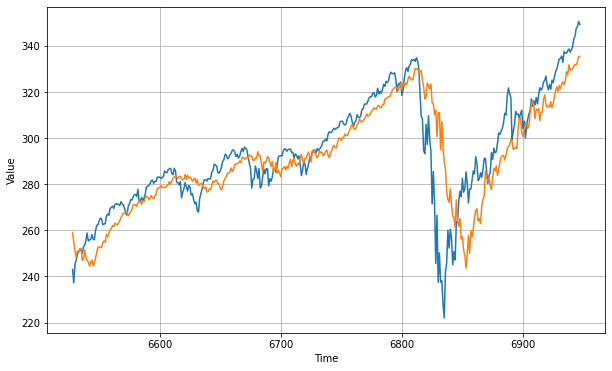

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test)
plot_series(x_test.index, dense_forecast)

#### Dense Model Result

In [ ]:
keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()

9.137429